In [1]:
import pandas as pd
from feature_engine.datetime import DatetimeFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import os
import pickle
import numpy as np
import warnings
import pandas as pd
from feature_engine.encoding import MeanEncoder, OneHotEncoder, OrdinalEncoder
from feature_engine.imputation import (
    ArbitraryNumberImputer,
    CategoricalImputer,
    MeanMedianImputer,
)
from feature_engine.selection import DropConstantFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sktime.transformations.series.summarize import WindowSummarizer
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import WindowFeatures, LagFeatures

import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
# for this feature

sns.set_context("talk")

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
CATEGORICAL_COLUMNS = ["holiday_name"]
NUMERICAL_COLUMNS = [
    "holiday",
    "shutdown",
    "mini_shutdown",
    "shops_closed",
    "winter_school_holidays",
    "school_holidays",
    "blackout",
    "mov_change",
    "frankfurt_shutdown",
    "year",
    "month",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "weekend",
]
DATE_COLUMNS = ["date"]

TARGET_COLUMNS = "orders"
FEATRURE_COLUMNS = NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS  # + DATE_COLUMNS
TRAIN_LEVEL = ["warehouse"]
MODEL_PATH = "model_registry"

In [3]:
# load the data
PATH = "./data/"
df_train = pd.read_csv(f"{PATH}train_new.csv", parse_dates=["date"], index_col="date")
df_train["split"] = "train"

df_test = pd.read_csv(f"{PATH}test_new.csv", parse_dates=["date"], index_col="date")
df_test["split"] = "test"

cols = df_train.columns
df_test = df_test[cols]

# df = pd.concat([df_train, df_test], axis=0)

In [4]:
df_test.head()

,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,...,snow,id,missing,year,month,day_of_month,day_of_week,day_of_year,weekend,split
date,,,,,,,,,,,,,,,,,,,,,
2024-03-16,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-16,0,2024,3,16,5,76,1,test
2024-03-17,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-17,0,2024,3,17,6,77,1,test
2024-03-18,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-18,0,2024,3,18,0,78,0,test
2024-03-19,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-19,0,2024,3,19,1,79,0,test
2024-03-20,Prague_1,NaN,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-20,0,2024,3,20,2,80,0,test


In [5]:
warehouse = df_train["warehouse"].unique()[0]
print(f"Warehouse: {warehouse}")
df_train = df_train.query(
    f"warehouse== '{warehouse}' and not {TARGET_COLUMNS}.isnull()"
)
df_test = df_test.query(f"warehouse== '{warehouse}'")
df = pd.concat([df_train, df_test], axis=0)
df_predict_all = pd.concat([df_train.iloc[-365:, :], df_test], axis=0)

Warehouse: Prague_1


In [6]:
# set the frequency of the time series to daily
# df_train.index.freq = "D"
# df_test.index.freq = "D"

# df_train.set_index("date", inplace=True,)
# df_test.set_index("date", inplace=True)

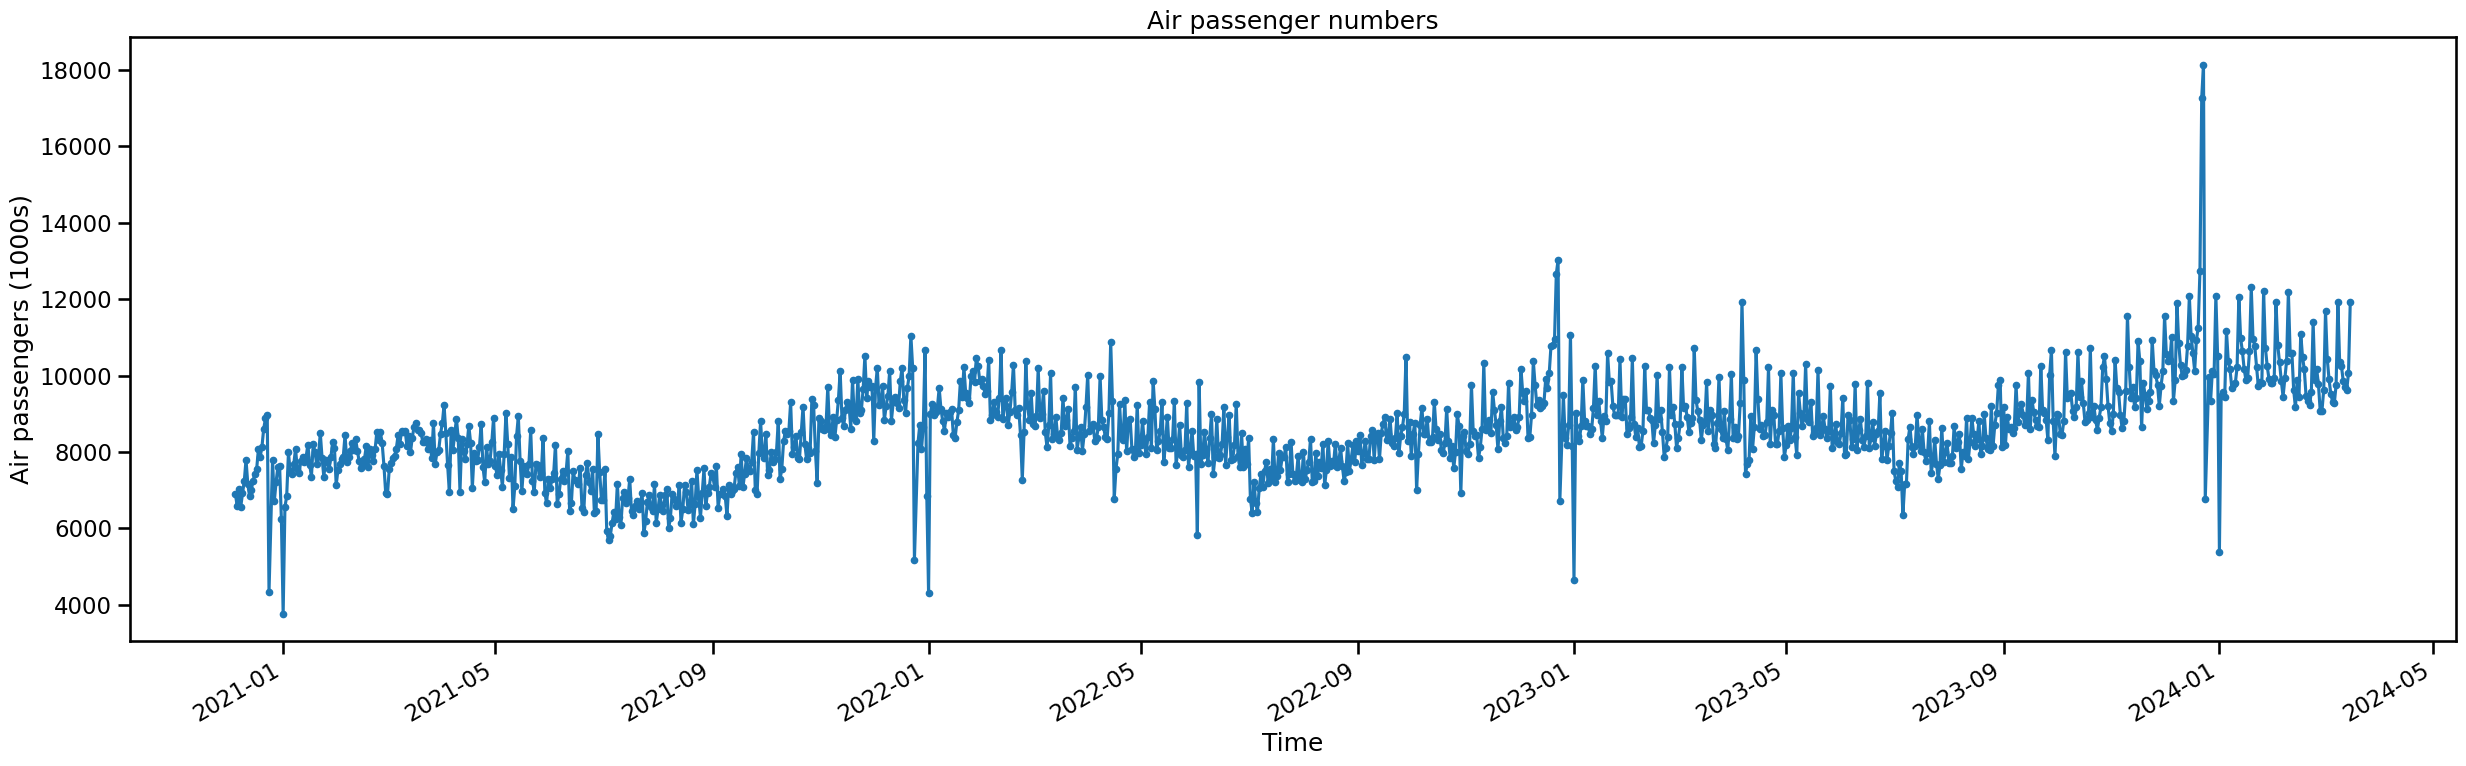

In [7]:
fig, ax = plt.subplots(figsize=[25, 7])
df_train.plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
# df_test.plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

In [8]:
pipeline = Pipeline(
    [
        # ('drop_na_lags', DropMissingData(variables=new_cols)),
        # Impute missing categorical except mean-encoded ones, normally happens in the test data
        (
            "missing_categoricals",
            CategoricalImputer(
                imputation_method="missing", variables=CATEGORICAL_COLUMNS
            ),
        ),
        # Impute 0 for missing numericals
        (
            "missing_numerical",
            ArbitraryNumberImputer(variables=NUMERICAL_COLUMNS, arbitrary_number=0),
        ),
        # OneHotEncode the rest of categorical
        (
            "onehot_encoding",
            OneHotEncoder(
                top_categories=6,
                variables=CATEGORICAL_COLUMNS,
                ignore_format=True,
            ),
        ),
        # Drop Constant features
        ("drop_constant", DropConstantFeatures(tol=1)),
        ("xgb", XGBRegressor(n_estimators=100, random_state=42)),
    ]
)

In [9]:
pipeline_lags = Pipeline(
    [
        (
            "lag_window",
            # Create window features using the transformer.
            WindowFeatures(
                variables=[TARGET_COLUMNS],
                functions=["mean"],
                window=[7],  # Day, week, year.
                freq="D",
                missing_values="ignore",
            ),
        ),
        (
            "lag_features",
            LagFeatures(
                variables=[TARGET_COLUMNS],
                periods=[1, 7, 365],
                freq="D",
                missing_values="ignore",
            ),
        ),
    ]
)

In [10]:
# pipeline_all = make_pipeline(pipeline_lags, pipeline)
# pipeline_all

In [11]:
df_train = df.query("split=='train'")[FEATRURE_COLUMNS + [TARGET_COLUMNS]].copy()
df_test = df.query("split=='test'")[FEATRURE_COLUMNS + [TARGET_COLUMNS]].copy()
df_predict = df_predict_all.copy()

print(df_train.shape, df_test.shape)

df_train_lags = pipeline_lags.fit_transform(df_train)
print(df_train_lags.shape)

new_cols = [col for col in df_train_lags.columns if col not in df_train.columns]
new_cols
df_train_lags.dropna(subset=new_cols, how="any", inplace=True)
print(df_train_lags.shape)

X_train = df_train_lags[FEATRURE_COLUMNS + new_cols]
y_train = df_train_lags[TARGET_COLUMNS]

print(X_train.shape, y_train.shape)

model = pipeline.fit(X_train, y_train)

(1193, 17) (61, 17)
(1193, 19)
(1182, 19)
(1182, 18) (1182,)


In [12]:
# forecast_time = df_train.index.max() + datetime.timedelta(days=1)
# forecast_time

In [13]:
for forecast_time in df_test.index:
    print(f"Forecasting for {forecast_time}")
    # print(df_predict[:forecast_time].shape)
    X_test = pipeline_lags.transform(
        df_predict[FEATRURE_COLUMNS + [TARGET_COLUMNS]][:forecast_time]
    )
    X_test_ = X_test.loc[[forecast_time]]

    y_pred = model.predict(X_test_[FEATRURE_COLUMNS + new_cols])
    # print(f"Predicted: {y_pred}")

    df_predict.loc[[forecast_time], TARGET_COLUMNS] = y_pred

Forecasting for 2024-03-16 00:00:00
Forecasting for 2024-03-17 00:00:00
Forecasting for 2024-03-18 00:00:00
Forecasting for 2024-03-19 00:00:00
Forecasting for 2024-03-20 00:00:00
Forecasting for 2024-03-21 00:00:00
Forecasting for 2024-03-22 00:00:00
Forecasting for 2024-03-23 00:00:00
Forecasting for 2024-03-24 00:00:00
Forecasting for 2024-03-25 00:00:00
Forecasting for 2024-03-26 00:00:00
Forecasting for 2024-03-27 00:00:00
Forecasting for 2024-03-28 00:00:00
Forecasting for 2024-03-29 00:00:00
Forecasting for 2024-03-30 00:00:00
Forecasting for 2024-03-31 00:00:00
Forecasting for 2024-04-01 00:00:00
Forecasting for 2024-04-02 00:00:00
Forecasting for 2024-04-03 00:00:00
Forecasting for 2024-04-04 00:00:00
Forecasting for 2024-04-05 00:00:00
Forecasting for 2024-04-06 00:00:00
Forecasting for 2024-04-07 00:00:00
Forecasting for 2024-04-08 00:00:00
Forecasting for 2024-04-09 00:00:00
Forecasting for 2024-04-10 00:00:00
Forecasting for 2024-04-11 00:00:00
Forecasting for 2024-04-12 0

In [14]:
df_predict

,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,...,snow,id,missing,year,month,day_of_month,day_of_week,day_of_year,weekend,split
date,,,,,,,,,,,,,,,,,,,,,
2023-03-16,Prague_1,8791.000000,no_holiday,0,0,0,0,0,0,0,...,1,Prague_1_2023-03-16,0,2023,3,16,3,75,0,train
2023-03-17,Prague_1,9817.000000,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2023-03-17,0,2023,3,17,4,76,0,train
2023-03-18,Prague_1,8544.000000,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2023-03-18,0,2023,3,18,5,77,1,train
2023-03-19,Prague_1,9109.000000,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2023-03-19,0,2023,3,19,6,78,1,train
2023-03-20,Prague_1,8977.000000,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2023-03-20,0,2023,3,20,0,79,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-11,Prague_1,9875.149414,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-05-11,0,2024,5,11,5,132,1,test
2024-05-12,Prague_1,9522.960938,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-05-12,0,2024,5,12,6,133,1,test
2024-05-13,Prague_1,9454.627930,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-05-13,0,2024,5,13,0,134,0,test


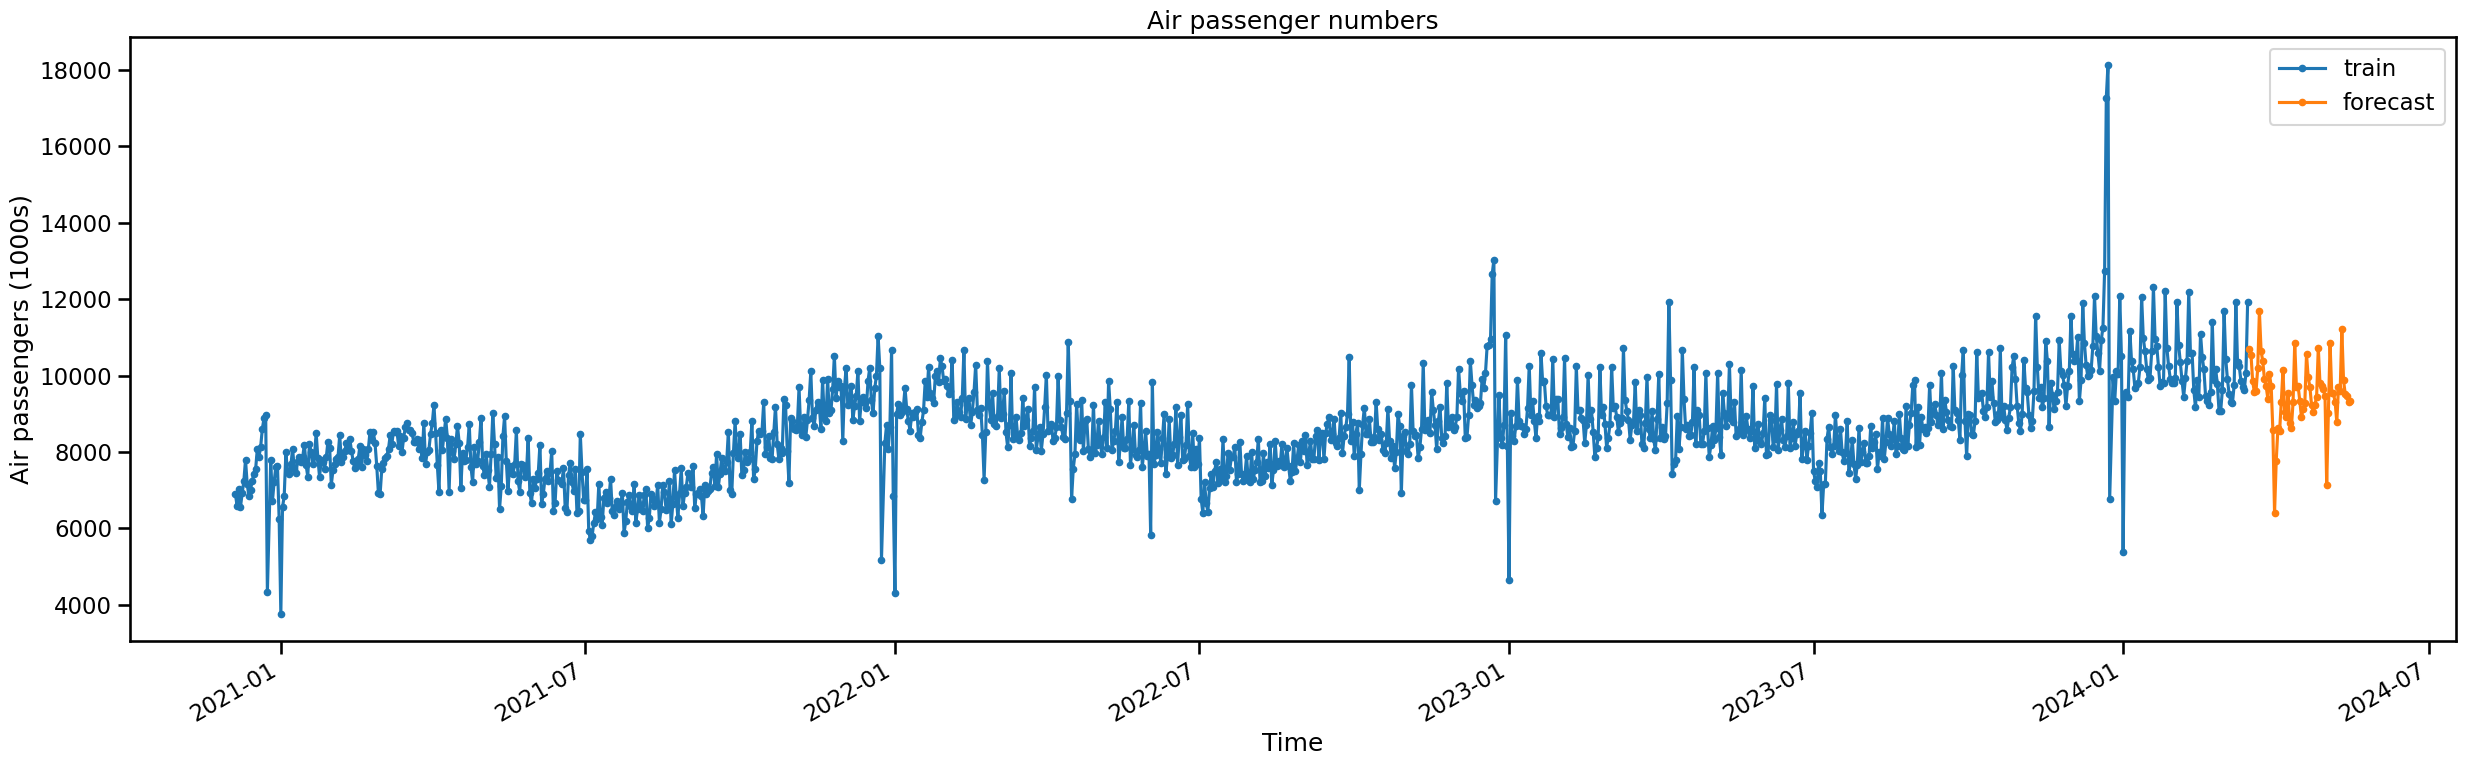

In [15]:
fig, ax = plt.subplots(figsize=[25, 7])
df_train.plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
df_predict.query("split=='test'").plot(
    y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax
)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
ax.legend(["train", "forecast"])
plt.tight_layout()

In [21]:
def train_predict(df, feature_columns, target_columns, max_lag=365):

    df_train = df.query("split=='train'")[feature_columns + [target_columns]].copy()
    df_test = df.query("split=='test'")[feature_columns + [target_columns]].copy()
    df_predict = df[
        (df.split == "test")
        | (
            (df.split == "train")
            & (df.index < (df_train.index.max() - datetime.timedelta(days=7)))
        )
    ]

    df_predict = pd.concat([df_train.iloc[-365:, :], df_test], axis=0)
    df_predict = df_predict_all.copy()

    print(df_train.shape, df_test.shape)

    df_train_lags = pipeline_lags.fit_transform(df_train)
    print(df_train_lags.shape)

    new_cols = [col for col in df_train_lags.columns if col not in df_train.columns]
    new_cols
    df_train_lags.dropna(subset=new_cols, how="any", inplace=True)
    print(df_train_lags.shape)

    X_train = df_train_lags[feature_columns + new_cols]
    y_train = df_train_lags[target_columns]

    print(X_train.shape, y_train.shape)

    model = pipeline.fit(X_train, y_train)

    for forecast_time in df_test.index:
        print(f"Forecasting for {forecast_time}")
        # print(df_predict[:forecast_time].shape)
        df_predcit_ = df_predict[feature_columns + [target_columns]].loc[:forecast_time]
        # print(df_predcit_.shape)
        X_test = pipeline_lags.transform(df_predcit_)
        X_test_ = X_test.loc[[forecast_time]]

        y_pred = model.predict(X_test_[feature_columns + new_cols])
        # print(f"Predicted: {y_pred}")

        df_predict.loc[[forecast_time], target_columns] = y_pred

    return df_predict.query("split=='test'")

In [22]:
train_predict(df, FEATRURE_COLUMNS, TARGET_COLUMNS, max_lag=365)

(1193, 17) (61, 17)
(1193, 19)
(1182, 19)
(1182, 18) (1182,)
Forecasting for 2024-03-16 00:00:00
Forecasting for 2024-03-17 00:00:00
Forecasting for 2024-03-18 00:00:00
Forecasting for 2024-03-19 00:00:00
Forecasting for 2024-03-20 00:00:00
Forecasting for 2024-03-21 00:00:00
Forecasting for 2024-03-22 00:00:00
Forecasting for 2024-03-23 00:00:00
Forecasting for 2024-03-24 00:00:00
Forecasting for 2024-03-25 00:00:00
Forecasting for 2024-03-26 00:00:00
Forecasting for 2024-03-27 00:00:00
Forecasting for 2024-03-28 00:00:00
Forecasting for 2024-03-29 00:00:00
Forecasting for 2024-03-30 00:00:00
Forecasting for 2024-03-31 00:00:00
Forecasting for 2024-04-01 00:00:00
Forecasting for 2024-04-02 00:00:00
Forecasting for 2024-04-03 00:00:00
Forecasting for 2024-04-04 00:00:00
Forecasting for 2024-04-05 00:00:00
Forecasting for 2024-04-06 00:00:00
Forecasting for 2024-04-07 00:00:00
Forecasting for 2024-04-08 00:00:00
Forecasting for 2024-04-09 00:00:00
Forecasting for 2024-04-10 00:00:00
For

,warehouse,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,...,snow,id,missing,year,month,day_of_month,day_of_week,day_of_year,weekend,split
date,,,,,,,,,,,,,,,,,,,,,
2024-03-16,Prague_1,10704.513672,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-16,0,2024,3,16,5,76,1,test
2024-03-17,Prague_1,10539.893555,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-17,0,2024,3,17,6,77,1,test
2024-03-18,Prague_1,9850.085938,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-18,0,2024,3,18,0,78,0,test
2024-03-19,Prague_1,9563.657227,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-19,0,2024,3,19,1,79,0,test
2024-03-20,Prague_1,9595.388672,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-03-20,0,2024,3,20,2,80,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-11,Prague_1,9875.149414,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-05-11,0,2024,5,11,5,132,1,test
2024-05-12,Prague_1,9522.960938,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-05-12,0,2024,5,12,6,133,1,test
2024-05-13,Prague_1,9454.627930,no_holiday,0,0,0,0,0,0,0,...,0,Prague_1_2024-05-13,0,2024,5,13,0,134,0,test
